In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Manaully Cleaning**

- Remove `<!-- IMAGE -->` tags
- Remove HTML tags like `<p>, </p>`
- Remove some garbage strings and texts

In [6]:
df_clean = pd.read_csv('/content/drive/MyDrive/Web IR/clean_processed_khmertext_dataset.csv', encoding='utf-8-sig')
df_clean.head()

,text,culture,economic,education,environment,health,politics,right,science
0,ដើម្បីស្តាប់ព័ត៌មាននេះ ក្រុមអ្នកជំនាញខាងធនធានរ...,0,0,0,1,0,0,0,0
1,ដើម្បីស្តាប់ព័ត៌មាននេះ ចាប់តាំងពីច្រើនសប្ដាហ៍ម...,0,0,0,1,0,0,0,0
2,ដើម្បីស្តាប់ព័ត៌មាននេះ បន្ទាប់ពីប្រទេសកម្ពុជា ...,0,0,0,1,0,0,0,0
3,ដើម្បីស្តាប់ព័ត៌មាននេះ ប្រទេសកម្ពុជាបានខាតបង់ទ...,0,0,1,0,0,0,0,0
4,ដើម្បីស្តាប់ព័ត៌មាននេះ ប្រទេសកម្ពុជាបានបើកយុទ្...,0,0,1,0,0,0,0,0


In [7]:
texts = df_clean['text']
labels = df_clean[['culture', 'economic', 'education', 'environment',
                   'health', 'politics', 'right', 'science']]

# 80% train, 10% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels,
    test_size=0.20,
    random_state=42,
    stratify=labels.values.argmax(axis=1)
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp.values.argmax(axis=1)
)

print(f"\nFinal splits:")
print(f"Train: {len(X_train)} samples ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df_clean)*100:.1f}%)")


Final splits:
Train: 5487 samples (80.0%)
Validation: 686 samples (10.0%)
Test: 686 samples (10.0%)


In [8]:
# Create new DataFrames
train_final = pd.DataFrame({'text': X_train})
val_final = pd.DataFrame({'text': X_val})
test_final = pd.DataFrame({'text': X_test})

# Add labels back
for col in labels.columns:
    train_final[col] = y_train[col].values
    val_final[col] = y_val[col].values
    test_final[col] = y_test[col].values

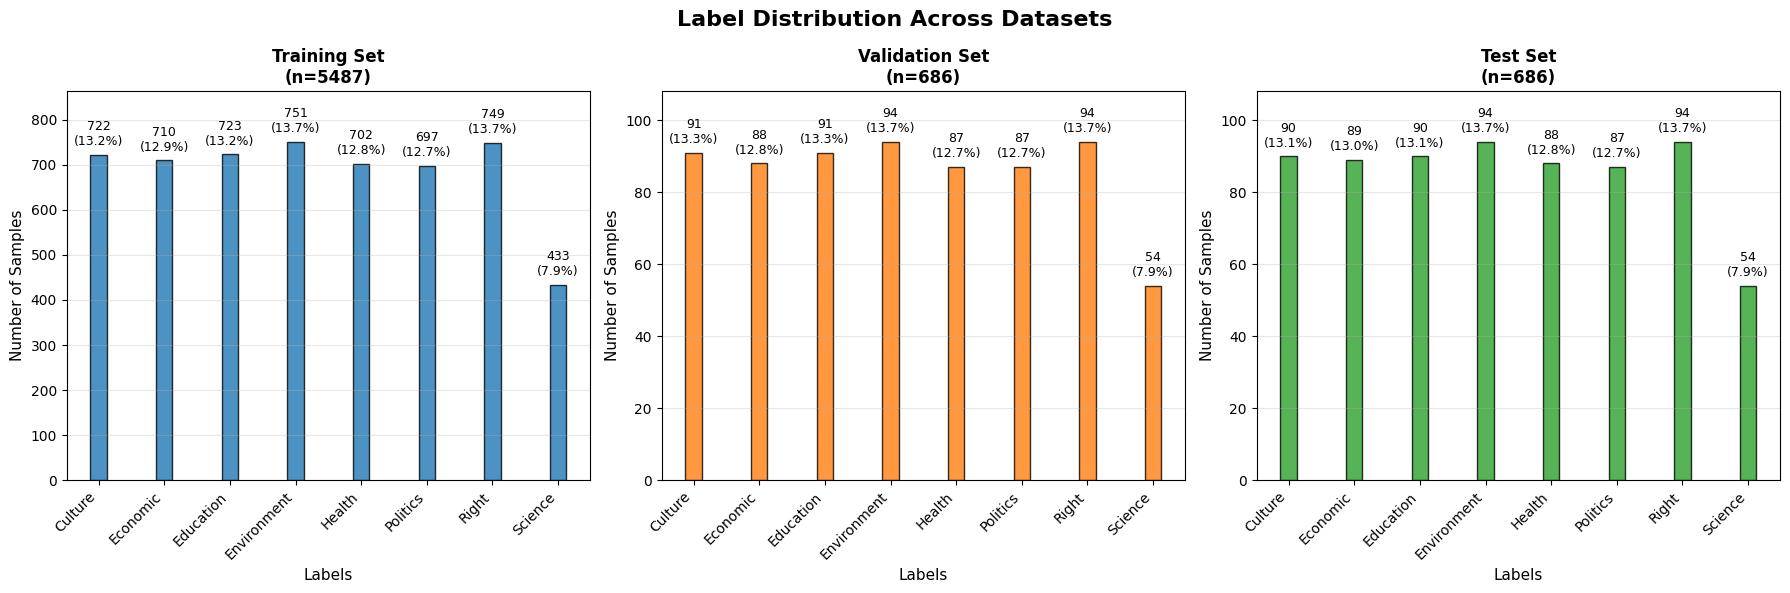

In [9]:
# Get label columns
label_cols = ['culture', 'economic', 'education', 'environment',
              'health', 'politics', 'right', 'science']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Label Distribution Across Datasets', fontsize=16, fontweight='bold')

# Define colors for each dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
dataset_names = ['Training Set', 'Validation Set', 'Test Set']
datasets = [train_final, val_final, test_final]

# Bar width and positions
x = np.arange(len(label_cols))
bar_width = 0.25

for idx, (ax, dataset, name, color) in enumerate(zip(axes, datasets, dataset_names, colors)):
    # Count positive samples for each label
    counts = [dataset[col].sum() for col in label_cols]
    percentages = [count / len(dataset) * 100 for count in counts]

    # Create bars
    bars = ax.bar(x, counts, width=bar_width, color=color, alpha=0.8, edgecolor='black')

    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax.text(i, count + max(counts)*0.02,
                f'{count}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=9)

    ax.set_title(f'{name}\n(n={len(dataset)})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Labels', fontsize=11)
    ax.set_ylabel('Number of Samples', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels([col.capitalize() for col in label_cols], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(counts) * 1.15)

plt.tight_layout()
plt.show()

# **Model Implementation**

In [ ]:
!pip install khmer-nltk
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.6 MB/s eta 0:00:00


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from khmernltk import word_tokenize
from joblib import load, dump
import re


from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [12]:
print(f"Loaded {len(english_stopwords)} English stopwords from NLTK")
print("Preview:", sorted(list(english_stopwords))[:20])

Loaded 198 English stopwords from NLTK
Preview: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been']


In [20]:
def clean_khmer_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Remove html tags
    text = re.sub(r'<[^>]+>', '', text)

    # 2. Remove zero-width characters
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)

    # 3. Remove punctuation (Latin + Khmer)
    text = re.sub(r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]', '', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def khmer_tokenize(text):
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned)

    processed_tokens = []
    for token in tokens:
        # Pure English token (letters/numbers only)?
        if re.match(r'^[a-zA-Z0-9]+$', token):
            token_lower = token.lower()
            # Remove if it's an NLTK English stopword
            if token_lower in english_stopwords:
                continue
            processed_tokens.append(token_lower)  # Lowercase content English words
        else:
            # Keep Khmer or mixed tokens as-is
            processed_tokens.append(token)

    return " ".join(processed_tokens)

In [21]:
# Apply to datasets
print("Tokenizing training data...")
train_final['text_tokenized'] = train_final['text'].apply(khmer_tokenize)


| 2026-01-06 06:19:05,854 | INFO | khmer-nltk | Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav |
INFO:khmer-nltk:Loaded model from /usr/local/lib/python3.12/dist-packages/khmernltk/word_tokenize/sklearn_crf_ner_10000.sav


Tokenizing training data...


In [22]:
print("\nSample sentences with their tokenized versions from the training set:")
for i in range(5):
    print(f"--- Sample {i+1} ---")
    print(f"Original: {train_final['text'].iloc[i]}")
    print(f"Tokenized: {train_final['text_tokenized'].iloc[i]}")
    print("\n")


Sample sentences with their tokenized versions from the training set:
--- Sample 1 ---
Original: ក្រសួងកសិកម្ម រុក្ខាប្រមាញ់និងនេសាទ បានច្រានចោលមតិរិះគន់តាមបណ្តាញសង្គមហ្វេសប៊ុកដែលបានលើកឡើងថា ក្រសួងមិនមានមន្ត្រីបច្ចេកទេសដើម្បីចុះជួយស្វែងរកទីផ្សារ ដែលបណ្តាលឲ្យតម្លៃស្រូវអង្ករធ្លាក់ចុះទាប មិនស្របទៅនឹងតម្លៃនៃវត្ថុធាតុដើម និងថ្លៃពលកម្មសម្រាប់ប្រជាកសិករ។ ចេញផ្សាយជាសាធារណៈនៅដើមសប្តាហ៍នេះថា ការលើកឡើងថាក្រសួងមិនជួយសម្រួលទប់តម្លៃស្រូវអង្ករមិនឲ្យធ្លាក់ចុះនោះ «ផ្ទុយពីការណ៍ពិតដែលក្រសួងកំពុងនឹងបានយកចិត្តទុកដាក់លើបញ្ហានេះ ជាហេតុធ្វើឲ្យសាធារណជនដែលមិនយល់ហេតុផលមានការភាន់ច្រឡំមកលើរាជរដ្ឋាភិបាល ជាពិសេសមកលើក្រសួងកសិកម្ម រុក្ខាប្រមាញ់និងនេសាទ»។ សេចក្តីប្រកាសព័ត៌មាននោះបានបន្ថែមថា យោងតាមការស្រាវជ្រាវរបស់ក្រសួងកសិកម្ម «ស្រូវនៅមានតម្លៃសមរម្យនៅឡើយ លើកលែងតែស្រូវដែលមានគុណភាពអន់តែប៉ុណ្ណោះ»។ លោក ចាន់ ហេង នាយករងខុទ្ទកាល័យ និងជាអ្នកនាំពាក្យនៃក្រសួងកសិកម្ម បានប្រាប់ VOA នៅថ្ងៃពុធនេះថា ក្រសួងបានសហការជាមួយរោងម៉ាស៊ីនកិនស្រូវដើម្បីប្រមូលទិញស្រូវពីកសិករ ហើយតម្លៃស្រូវបានឡើងដល់កម្រិតដែលអាចទទួលយកបានហើយ។ «តាមពិតក្រសួងបានចាត់វិធ

In [23]:
print("Tokenizing validation data...")
val_final['text_tokenized'] = val_final['text'].apply(khmer_tokenize)

Tokenizing validation data...


In [25]:
print("\nSample sentences with their tokenized versions from the validation set:")
for i in range(5):
    print(f"--- Sample {i+1} ---")
    print(f"Original: {val_final['text'].iloc[i]}")
    print(f"Tokenized: {val_final['text_tokenized'].iloc[i]}")
    print("\n")


Sample sentences with their tokenized versions from the validation set:
--- Sample 1 ---
Original: រដ្ឋាភិបាលអ៊ីតាលីបានចេញបទបញ្ជាបន្ទាន់ថ្មីមួយនៅថ្ងៃអាទិត្យនេះដើម្បីដាក់កំហិតការធ្វើដំណើររបស់ប្រជាពលរដ្ឋអ៊ីតាលីប្រហែល ២៥ ភាគរយ។ ប្រទេសអ៊ីតាលីមានករណីស្លាប់ដោយសារជំងឺ COVID-19 ច្រើនជាងប្រទេសណាៗទាំងអស់ក្រៅពីប្រទេសចិន។ បន្ទាប់ពីមានករណីស្លាប់ដោយសារជំងឺនេះជាង ២៣០ ករណីមក រដ្ឋាភិបាលអ៊ីតាលីបានសម្រេចបិទតំបន់ភាគខាងជើងនៃប្រទេស ដែលក្នុងនោះមានទាំងតំបន់ Lombardy និងទីក្រុង Milan ដែលជាទីក្រុងហិរញ្ញវត្ថុផងដែរ។ ជាងនេះទៀត រដ្ឋាភិបាលនឹងបិទខេត្តចំនួន ១៤ ផ្សេងទៀត ដែលរួមមានទាំងខេត្ត Veneto ដែលជាទីតាំងនៃទីក្រុង Venice ផងដែរ។ ការធ្វើដំណើរចូលនិងចេញពីតំបន់ទាំងនេះនឹងរងការដាក់កំហិតតឹងតែងរហូតដល់ដើមខែក្រោយ ស្របពេលដែលរដ្ឋាភិបាលអ៊ីតាលីកំពុងប្រឹងប្រែងធ្វើយ៉ាងណាឲ្យចំនួនអ្នកស្លាប់ដោយសារមេរោគកូរ៉ូណាថ្មីនេះធ្លាក់ចុះ។ បន្ថែមពីនេះទៀត រដ្ឋាភិបាលអ៊ីតាលីបានបញ្ជាឲ្យបិទសារមន្ទីរ រោងមហោស្រព រោងភាពយន្ត និងកន្លែងកម្សាន្តផ្សេងៗទៀត។ ជាងនេះទៀត អ៊ីតាលីបានស្នើឲ្យគ្រូពេទ្យចូលនិវត្តន៍នានាត្រឡប់មកជួយដើម្បីរារាំងការឆ្លងរាលដាលបន្ថែមទៀតនៃមេរោគនេះ។

In [26]:
print("Tokenizing testing data...")
test_final['text_tokenized'] = test_final['text'].apply(khmer_tokenize)

Tokenizing testing data...


In [27]:
print("\nSample sentences with their tokenized versions from the testing set:")
for i in range(5):
    print(f"--- Sample {i+1} ---")
    print(f"Original: {test_final['text'].iloc[i]}")
    print(f"Tokenized: {test_final['text_tokenized'].iloc[i]}")
    print("\n")


Sample sentences with their tokenized versions from the testing set:
--- Sample 1 ---
Original: សកម្មជនគាំទ្រលទ្ធិប្រជាធិបេតយ្យក្រុងហុងកុង ១០ នាក់ ត្រូវបានកាត់ទោសឲ្យជាប់ពន្ធនាគារនៅចិនដីគោក ចំពោះការប៉ុនប៉ងរត់គេចខ្លួនចេញពីទីក្រុងពាក់កណ្តាលស្វយ័តនេះ តាមទូកលឿននៅពាក់កណ្តលឆ្នាំនេះ។ ក្នុងអំឡុងពេលនៃសវនាការតុលាការ នៅក្នុងទីក្រុង Shenzhen ភាគខាងត្បូងចិន នៅថ្ងៃពុធនេះ សកម្មជន ៨ នាក់ ត្រូវបានកាត់ទោសឲ្យជាប់ពន្ធនាគារ ៧ ខែ ចំពោះបទចោទប្រកាន់ពីការឆ្លងកាត់ព្រំដែនខុសច្បាប់ នៅពេលដែលពួកគេត្រូវបានចាប់ខ្លួនកាលពីខែសីហា ដោយឆ្មាំការពារដែនសមុទ្រចិន ខណៈដែលព្យាយាមគេចទៅកាន់កោះតៃវ៉ាន់។ សកម្មជន ២ នាក់ទៀតគឺឈ្មោះ Quinn Moon អាយុ ៣៣ ឆ្នាំ និង Tang Kai-yin អាយុ ៣១ ឆ្នាំ ត្រូវបានចោទប្រកាន់ពីការរៀបចំការឆ្លងដែនខុសច្បាប់ ហើយត្រូវបានកាត់ទោសឲ្យជាប់ពន្ធនាគារ រយៈពេល ២ ឆ្នាំនិង ៣ ឆ្នាំ។ សកម្មជនទាំងអស់ ក៏នឹងទទួលការផាកពិន័យប្រាក់ពីរវាង ១.៥០០ ដុល្លារទៅ ៣.០០០ ដុល្លារដែរ។ ជនជាប់ចោទ ត្រូវបានគេនិយាយថា បានសារភាពទទួលកំហុស ដោយសង្ឃឹមថា បានទទួលការបន្ធូរបន្ថយទោស។ ពួករដ្ឋអាជ្ញា បាននិយាយថា អនីតិជន ២ នាក់ដែលត្រូវបានចាប់ខ្លួនដែរ នៅពេលធ្វើដំណើរមិន

In [28]:
# Safety cleanup: Ensure all text_tokenized are non-empty strings
def safe_string(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    return text.strip()

train_final['text_tokenized'] = train_final['text_tokenized'].apply(safe_string)
val_final['text_tokenized']   = val_final['text_tokenized'].apply(safe_string)
test_final['text_tokenized']  = test_final['text_tokenized'].apply(safe_string)

print("Any non-string or empty after cleanup?")
print("Train: ", train_final['text_tokenized'].apply(lambda x: not isinstance(x, str) or not x).sum())
print("Validation: ", val_final['text_tokenized'].apply(lambda x: not isinstance(x, str) or not x).sum())
print("Test: ", test_final['text_tokenized'].apply(lambda x: not isinstance(x, str) or not x).sum())

Any non-string or empty after cleanup?
Train:  60
Validation:  9
Test:  8


In [29]:
# Save tokenized datasets for later use
train_final.to_csv('/content/drive/MyDrive/Web IR/train_tokenized.csv', index=False, encoding='utf-8-sig')
val_final.to_csv('/content/drive/MyDrive/Web IR/val_tokenized.csv', index=False, encoding='utf-8-sig')
test_final.to_csv('/content/drive/MyDrive/Web IR/test_tokenized.csv', index=False, encoding='utf-8-sig')

print("Tokenized datasets saved:")
print(f"  - train_tokenized.csv ({len(train_final)} samples)")
print(f"  - val_tokenized.csv ({len(val_final)} samples)")
print(f"  - test_tokenized.csv ({len(test_final)} samples)")

Tokenized datasets saved:
  - train_tokenized.csv (5487 samples)
  - val_tokenized.csv (686 samples)
  - test_tokenized.csv (686 samples)


# **BOW Model**

In [30]:
count_vec = CountVectorizer(
    analyzer=str.split,
    max_features=8000,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

X_train_count = count_vec.fit_transform(train_final['text_tokenized'])
X_val_count   = count_vec.transform(val_final['text_tokenized'])
X_test_count  = count_vec.transform(test_final['text_tokenized'])

print(f"Raw BoW (Count) matrix shape: {X_train_count.shape}")

Raw BoW (Count) matrix shape: (5487, 8000)


# **TF-IDF Vectorization + TruncatedSVD**

In [31]:
tfidf = TfidfVectorizer(
    lowercase=False,          # Khmer has no case
    max_features=8000,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2),
    analyzer=str.split        # Use str.split as text is pre-tokenized
)

X_train_tfidf = tfidf.fit_transform(train_final['text_tokenized'])
X_val_tfidf   = tfidf.transform(val_final['text_tokenized'])
X_test_tfidf  = tfidf.transform(test_final['text_tokenized'])

print(f"Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"TF-IDF shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF shape (val): {X_val_tfidf.shape}")
print(f"TF-IDF shape (test): {X_test_tfidf.shape}")

Vocabulary size: 8,000
TF-IDF shape (train): (5487, 8000)
TF-IDF shape (val): (686, 8000)
TF-IDF shape (test): (686, 8000)


In [32]:
feature_names = np.array(tfidf.get_feature_names_out())
label_columns = ['culture', 'economic', 'education', 'environment',
                 'health', 'politics', 'right', 'science']

top_n = 10

print("="*80)
print("TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY")
print("="*80)

for label in label_columns:
    pos_mask = (y_train.iloc[:, label_columns.index(label)] == 1).values
    pos_count = pos_mask.sum()

    if pos_count == 0:
        print(f"\n{label.upper():<12} : No positive samples")
        continue

    avg_tfidf = np.asarray(X_train_tfidf[pos_mask].mean(axis=0)).ravel()

    top_idx = avg_tfidf.argsort()[-top_n:][::-1]

    print(f"\n{label.upper():<12} (n = {pos_count} articles)")
    print("-" * 50)
    for i, idx in enumerate(top_idx):
        term = feature_names[idx]
        score = avg_tfidf[idx]
        print(f"{i+1:2}. {term:<20} {score:.4f}")

TOP 10 DISCRIMINATIVE TF-IDF TERMS PER CATEGORY

CULTURE      (n = 722 articles)
--------------------------------------------------
 1. ខ្មែរ                0.0605
 2. កម្ពុជា              0.0456
 3. បុណ្យ                0.0424
 4. ឆ្នាំ                0.0415
 5. ពិធី                 0.0385
 6. ខ្ញុំ                0.0364
 7. យើង                  0.0363
 8. សិល្បៈ               0.0359
 9. ប្រទេស               0.0329
10. វប្បធម៌              0.0324

ECONOMIC     (n = 710 articles)
--------------------------------------------------
 1. ចិន                  0.0835
 2. ប្រទេស               0.0759
 3. ពាណិជ្ជកម្ម          0.0604
 4. អាមេរិក              0.0562
 5. កម្ពុជា              0.0550
 6. សេដ្ឋកិច្ច           0.0490
 7. ពន្ធ                 0.0481
 8. អឺរ៉ុប               0.0474
 9. សហរដ្ឋ               0.0416
10. មិន                  0.0403

EDUCATION    (n = 723 articles)
--------------------------------------------------
 1. កម្ពុជា              0.0592
 2. សិស្ស                0.0

### Explained Variance by TruncatedSVD Components

Let's visualize how much variance each component explains to help us choose the optimal number of components for our model.

Components needed for >=80% variance: 1170 (actual: 0.8001)
Components needed for >=85% variance: 1467 (actual: 0.8501)
Components needed for >=90% variance: 1878 (actual: 0.9001)


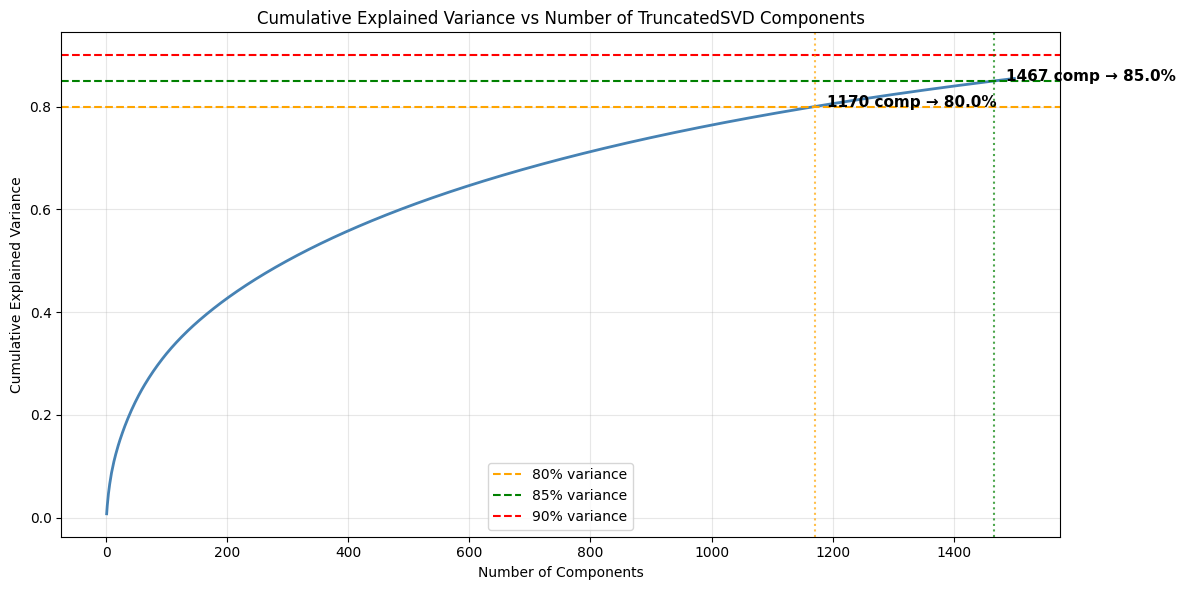

In [33]:
max_components = min(8000, X_train_tfidf.shape[1] - 1)

svd_full = TruncatedSVD(n_components=max_components, random_state=42)
svd_full.fit(X_train_tfidf)

cumulative_variance = np.cumsum(svd_full.explained_variance_ratio_)

# Find the smallest n where variance >= target
targets = [0.80, 0.85, 0.90]
optimal_ns = {}

for target in targets:
    n = np.argmax(cumulative_variance >= target) + 1
    optimal_ns[target] = n
    print(f"Components needed for >={target*100:.0f}% variance: {n} (actual: {cumulative_variance[n-1]:.4f})")

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance[:1500])+1), cumulative_variance[:1500],
         color='steelblue', linewidth=2)
plt.axhline(y=0.80, color='orange', linestyle='--', label='80% variance')
plt.axhline(y=0.85, color='green', linestyle='--', label='85% variance')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance')

for target, n in optimal_ns.items():
    if n <= 1500:
        plt.axvline(x=n, color={0.80:'orange', 0.85:'green', 0.90:'red'}[target],
                    linestyle=':', alpha=0.7)
        plt.text(n+20, target, f'{n} comp → {target*100}%', fontsize=11, fontweight='bold')

plt.title("Cumulative Explained Variance vs Number of TruncatedSVD Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
max_components = min(
    X_train_tfidf.shape[0] - 1,   # n_samples - 1
    X_train_tfidf.shape[1] - 1    # n_features - 1
)

n_components = min(8000, max_components)
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(f"TruncatedSVD shape (train): {X_train_svd.shape}")
print(f"TruncatedSVD shape (val): {X_val_svd.shape}")
print(f"TruncatedSVD shape (test): {X_test_svd.shape}")

TruncatedSVD shape (train): (5487, 5486)
TruncatedSVD shape (val): (686, 5486)
TruncatedSVD shape (test): (686, 5486)


In [36]:
print("n_components used:", n_components)


n_components used: 5486


## **2D Visualization of Class Separability**

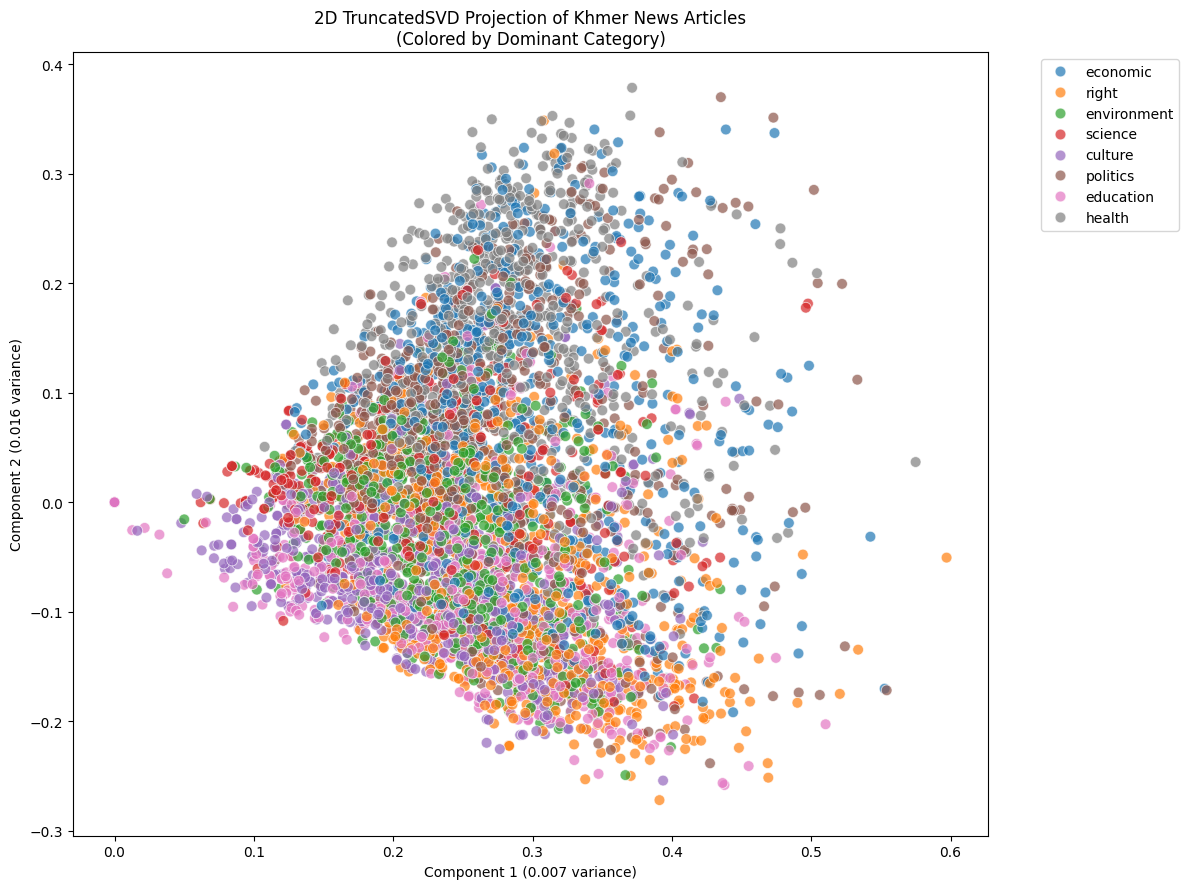

In [35]:
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X_train_tfidf)

dominant_idx = np.argmax(y_train, axis=1)
dominant_labels = [label_cols[i] for i in dominant_idx]

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=dominant_labels,
    palette='tab10',
    alpha=0.7,
    s=60
)
plt.title("2D TruncatedSVD Projection of Khmer News Articles\n(Colored by Dominant Category)")
plt.xlabel(f"Component 1 ({svd_2d.explained_variance_ratio_[0]:.3f} variance)")
plt.ylabel(f"Component 2 ({svd_2d.explained_variance_ratio_[1]:.3f} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Train Classifiers with Class Imbalance Handling**

In [ ]:
classifiers = {
    "Logistic Regression": OneVsRestClassifier(
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    ),
    "Linear SVM": OneVsRestClassifier(
        LinearSVC(class_weight='balanced', random_state=42)
    ),
    "Random Forest": OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=300,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    ),
    "XGBoost": OneVsRestClassifier(
        XGBClassifier(
            scale_pos_weight=5,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
    ),
    "LightGBM": OneVsRestClassifier(
        LGBMClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    )
}

In [ ]:
results = {}

print("Training and evaluating models...\n")
for name, clf in classifiers.items():
    print(f"→ Training {name}...")
    clf.fit(X_train_svd, y_train)

    y_pred = clf.predict(X_val_svd)

    macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    results[name] = macro_f1

    print(f"{name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(y_val, y_pred, target_names=label_cols, zero_division=0))
    print("-" * 60)

## **Confusion Matrices Per Category**

In [ ]:
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]
y_pred_best = best_clf.predict(X_val_svd)

print(f"Plotting confusion matrices using: {best_model_name}")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_val[:, i], y_pred_best[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                ax=axes[i],
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f"{label}\n(pos: {y_val[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Evaluate best model on TEST set
print("\n" + "="*80)
print(f"STEP 1: TEST SET EVALUATION - {best_model_name}")
print("="*80)

y_pred_test = best_clf.predict(X_test_svd)
test_macro_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print("\n" + classification_report(y_test, y_pred_test, target_names=label_cols, zero_division=0))

# Confusion matrices for test set
print("\n" + "="*80)
print("Test Set Confusion Matrices per Category")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_test[:, i], y_pred_test[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                ax=axes[i],
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f"{label}\n(pos: {y_test[:, i].sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Test Set Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Step 2: Compare metrics across TRAIN, VAL, and TEST sets
print("\n" + "="*80)
print("STEP 2: COMPARING METRICS ACROSS TRAIN, VAL, TEST SETS")
print("="*80)

# Get predictions for all sets
y_pred_train = best_clf.predict(X_train_svd)

# Calculate F1 scores for all three sets
train_macro_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
val_macro_f1 = f1_score(y_val, y_pred_best, average='macro', zero_division=0)  # Already calculated
# test_macro_f1 already calculated above

# Create comparison table
comparison_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Macro F1': [train_macro_f1, val_macro_f1, test_macro_f1],
    'Samples': [len(y_train), len(y_val), len(y_test)]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerformance Summary Across All Splits:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: F1 Score Comparison
axes[0].bar(comparison_df['Dataset'], comparison_df['Macro F1'],
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Macro F1 Score', fontsize=12)
axes[0].set_title(f'F1 Score Comparison\n{best_model_name}', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Annotate bars
for i, (dataset, f1) in enumerate(zip(comparison_df['Dataset'], comparison_df['Macro F1'])):
    axes[0].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Sample Distribution
axes[1].bar(comparison_df['Dataset'], comparison_df['Samples'],
            color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Sample Distribution Across Splits', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Annotate bars
for i, (dataset, count) in enumerate(zip(comparison_df['Dataset'], comparison_df['Samples'])):
    axes[1].text(i, count + 20, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detect overfitting
print("\n" + "-"*80)
print("Overfitting Analysis:")
print("-"*80)
f1_drop_val = (train_macro_f1 - val_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0
f1_drop_test = (train_macro_f1 - test_macro_f1) / train_macro_f1 * 100 if train_macro_f1 > 0 else 0

print(f"Train → Val F1 drop: {f1_drop_val:.2f}%")
print(f"Train → Test F1 drop: {f1_drop_test:.2f}%")

if f1_drop_test < 5:
    print("✓ Excellent generalization: Test performance is close to training")
elif f1_drop_test < 15:
    print("✓ Good generalization: Reasonable gap between training and test")
else:
    print("⚠ Potential overfitting: Significant gap between training and test performance")


# **Saving and Loading Each Model**

In [ ]:
# Save each classifier (including the OneVsRest wrapper)
dump(classifiers["Logistic Regression"], '/content/drive/MyDrive/Web IR/Model/logistic_regression_model_all_com.joblib')
dump(classifiers["Linear SVM"], '/content/drive/MyDrive/Web IR/Model/linear_svm_model__all_com.joblib')
dump(classifiers["Random Forest"], '/content/drive/MyDrive/Web IR/Model/random_forest_model_all_com.joblib')
dump(classifiers["XGBoost"], '/content/drive/MyDrive/Web IR/Model/xgboost_model_all_com.joblib')
dump(classifiers["LightGBM"], '/content/drive/MyDrive/Web IR/Model/lightgbm_model_all_com.joblib')

# Also save the preprocessing objects (critical for inference!)
dump(tfidf, '/content/drive/MyDrive/Web IR/Model/tfidf_vectorizer.joblib')
dump(svd, '/content/drive/MyDrive/Web IR/Model/truncated_svd.joblib')

print("Models and preprocessors saved successfully!")

In [ ]:
# Load everything
tfidf_loaded = load('/content/drive/MyDrive/Web IR/Model/tfidf_vectorizer.joblib')
svd_loaded   = load('/content/drive/MyDrive/Web IR/Model/truncated_svd.joblib')
logreg_loaded = load('/content/drive/MyDrive/Web IR/Model/logistic_regression_model_all_com.joblib')

## **Test on new data**

In [ ]:
# Preprocess new text exactly like training
new_texts = ["អត្ត ព លិ ក ថៃ ចំនួន ៨ នាក់ ដែល ចូលរួម ប្រកួតប្រជែង នៅ ក្នុង ព្រឹត្តិការណ៍ កីឡា ស៊ី ហ្គេ ម លើក ទី ៣៣ ឆ្នាំ ២០២៥ ត្រូវ បាន បញ្ជូន ទៅ កាន់ មន្ទីរពេទ្យ ក្នុង ខេត្ត ឈុ ន បុរី ( ) ខេត្ត ឈុ ន បុរី ៖ អត្ត ព លិ ក ថៃ ចំនួន ៨ នាក់ ដែល ចូលរួម ប្រកួតប្រជែង នៅ ក្នុង ព្រឹត្តិការណ៍ កីឡា ស៊ី ហ្គេ ម លើក ទី ៣៣ ឆ្នាំ ២០២៥ ត្រូវ បាន បញ្ជូន ទៅ កាន់ មន្ទីរពេទ្យ ក្នុង ខេត្ត ឈុ ន បុរី ( ) ដោយ មាន រោគ សញ្ញា មិន ស្រួលខ្លួន ខ្លាំង ដោយសារ ការ ពុល អាហារ។ បើ តាម ក្រុម ជួយ សង្គ្រោះ ខេត្ត ឈុ ន បុរី បានឱ្យ ដឹង ថា ពួក គេ ត្រូវ បាន ជូនដំណឹង នៅ ល្ងាច ថ្ងៃ ទី ១២ ខែធ្នូ ឆ្នាំ ២០២៥ អំពី ករណី សង្គ្រោះ បន្ទាន់ មនុស្ស ចំនួន ៨ នាក់ ក្នុង កន្លែង ស្នាក់ នៅ របស់ ក្រុម អត្ត ព លិ ក កីឡា ស៊ី ហ្គេ ម។ អត្ត ព លិ ក ទាំងនោះ បង្ហាញ អាកា រៈ មិន ស្រួលខ្លួន ខ្លាំង ដោយសារ ឈឺពោះ ក្អួតចង្អោរ វិលមុខ និង រាគ ហើយ ត្រូវ បាន បញ្ជូន ទៅ មន្ទីរពេទ្យ ខេត្ត ឈុ ន បុរី ដើម្បី ព្យាបាល។ មន្ត្រី ពេទ្យ ក្រោយមក បាន បញ្ជាក់ ថា អត្ត ព លិ ក ទាំង ៨ នាក់ នោះ គឺជា សមាជិក ក្រុម ជម្រើសជាតិ ថៃ ផ្ទាល់ តែ ម្តង ដោយ ក្នុង ៧ នាក់ ជា អត្ត ព លិ ក កីឡាបាល់ទះ។ យោង តាម ការ បញ្ជាក់ ពី លោក វេជ្ជបណ្ឌិត ស៊ឺ ម សក្តិ ស៊ូ ម៉ា ណុ ន ( ) ប្រធាន គណៈកម្មាធិការ វេជ្ជសាស្ត្រ គណៈប្រតិភូ ថៃ ថា អត្ត ព លិ ក ទាំងនោះ បាន ញ៉ាំ អាហារ ប្រអប់ ពី សណ្ឋាគារ ខាងក្រៅ ពេល អាហារ ថ្ងៃត្រង់ នៅ ថ្ងៃ ទី ១១ ខែធ្នូ កន្លង ទៅ មុន ពេល ពួក គេ ចូល ទៅ កាន់ កន្លែង ស្នាក់ នៅ ផ្លូវការ របស់ អត្ត ព លិ ក កីឡា ស៊ី ហ្គេ ម។ លោក បាន គូសបញ្ជាក់ ដូច្នេះ ថា អាហារ ត្រូវ បាន បរិភោគ មុន ពេល អត្ត ព លិ ក ចូល ទៅ ក្នុង កន្លែង ស្នាក់ នៅ របស់ អ្នក រៀបចំ ហើយ មិន មាន ទំនាក់ទំនង ជាមួយ អាហារ ដែល ផ្តល់ ដោយ អ្នក រៀបចំ កីឡា ស៊ី ហ្គេ ម នោះ ទេ។ យ៉ាងណាមិញ ស្ថានភាព របស់ អត្ត ព លិ ក ទាំងនោះ ត្រូវ បាន រាយការណ៍ ថា វិល មក រក ភាព ប្រក្រតី វិញ ហើយ។ ក្រុម ទាំងនោះ ក៏ ត្រូវ បាន អនុញ្ញាត ឱ្យ ចេញពី មន្ទីរពេទ្យ និង វិល ត្រឡប់ ទៅ កាន់ សណ្ឋាគារ របស់ ក្រុម វិញ ផង ដែរ។ ទោះ យ៉ាងណា នៅ ទីនោះ បុគ្គលិក ពេទ្យ នឹង បន្ត តាមដាន សុខភាព របស់ ពួក គេ បន្ថែម ទៀត។ រឿងរ៉ាវ នេះ បាន និង កំពុង ទាក់ទាញ ការ ចាប់អារម្មណ៍ ឡើង វិញ ចំពោះ ការ រៀបចំ អាហារ នៅ ក្នុង ព្រឹត្តិការណ៍ កីឡា ស៊ី ហ្គេ ម លើក ទី ៣៣ ដែល ប្រទេស ថៃ ជា ម្ចាស់ផ្ទះ ខណៈ ដែល កន្លង មក គណៈប្រតិភូ កីឡា ជា ច្រើន បាន រាយការណ៍ ពី ភាព ចម្រុះ នៃ អាហារ មាន កម្រិត និង មិន គ្រប់គ្រាន់ ដែល ជា បញ្ហា ប្រឈម នៃ របប អាហារ របស់ បណ្តា អត្ត ព លិ ក ជា ពិសេស សម្រាប់ ក្រុម មាន តម្រូវការ អាហារូបត្ថម្ភ ខ្ពស់ ឬ ប្រទេស កាន់សាសនា អ៊ី ស្លា ម។ ជាក់ស្តែង ក្រុម វៀតណាម រួម ទាំង ក្រុមបាល់ទាត់ ហ្វុ ត សាល និង បាល់ទះ ក៏ ធ្លាប់ បាន លើក ឡើង ពី ការ ព្រួយបារម្ភ អំពី មុខម្ហូប ដដែល   និង អាហារ ប្រអប់ តូច   នៅ សណ្ឋាគារ នៅ ទីក្រុង បាងកក និង ខេត្ត ឈុ ន បុរី។ សហព័ន្ធ បាល់ទាត់ វៀតណាម បាន លើក ឡើង ថា ខ្លួន បាន រំពឹង ទុក ពី បញ្ហា បែប នេះ រួប ហើយ ដោយ បាន រៀបចំ អាហារ បន្ថែម ពី ភោជនីយដ្ឋាន វៀតណាម នៅ ក្នុង ប្រទេស ថៃ ផ្ទាល់ តែ ម្តង។ ក្រៅពី វៀតណាម ងាក ទៅ ម៉ា ឡេ ស៊ី ក៏ បាន ត្អូញត្អែរ ផង ដែរ ថា ការ រៀបចំ អាហារ ហា ឡា ល់ ( ) ដែល សន្យា ដោយ ប្រទេស ម្ចាស់ផ្ទះ ថៃ មិន បាន បំពេញតម្រូវការ ប្រចាំ ថ្ងៃ ជាប់លាប់ នោះ ទេ។ ក្រៅពី បញ្ហា អាហារ គណៈប្រតិភូ មួយ ចំនួន ក៏ បាន រាយការណ៍ ពី បញ្ហា ភស្តុ ភារ កម្ម រាប់ ចាប់ពី ការ ដឹក ជញ្ជូន ចេញពី អាកាសយានដ្ឋាន យឺត ពេល រហូត ដល់ ការ ច្រឡំ កន្លែង ស្នាក់ នៅ នៅ ខេត្ត ឈៀង ម៉ៃ។ វៀតណាម ក៏ បាន តវ៉ា ប្រឆាំង នឹង កំហុសឆ្គង ម្តង ហើយ ម្តងទៀត ដែល ពាក់ព័ន្ធ នឹង ការ ប្រើប្រាស់ ទង់ជាតិ របស់ ខ្លួន អំឡុង ពេល ផ្សាយ តាម ទូរទស្សន៍ និង ពិធី ប្រគល់ មេដាយ រួម ទាំង កំហុសឆ្គង អំឡុង ពេល ការ ប្រកួត បាល់ទាត់ បុរស 22 ទល់ នឹង ម៉ា ឡេ ស៊ី ផង ដែរ។ ពាក់ព័ន្ធ បញ្ហា នេះ អាជ្ញាធរ កីឡា ថៃ ( ) បាន ទទួលស្គាល់ ព្រមទាំង បាន សន្យា ថា នឹង ចាត់វិធានការ កែតម្រូវ ឱ្យ បាន ឆាប់រហ័ស។ ទោះ យ៉ាងណា ក៏ ដោយ ប្រធាន គណៈប្រតិភូ ថៃ លោក ថា ណា ឆៃ ប្រា សិទ្ធិ ( ) បាន ព្រមាន ថា ការ ធ្វេសប្រហែស ប្រតិបត្តិការ ម្តង ហើយ ម្តងទៀត នេះ អាច ប៉ះពាល់ ដល់ មុខមាត់ របស់ ប្រទេស ថៃ ក្នុង នាម ជា ម្ចាស់ផ្ទះ ព្រឹត្តិការណ៍ កីឡា ស៊ី ហ្គេ ម ៕",
             "សហរដ្ឋអាមេរិក ៖ បន្ទាប់ ពី ចំណាយពេល ជិត ២៥ ឆ្នាំ ក្នុង សង្វៀន ប្រកួត កីឡា ចំបាប់ ឬ កីឡាកាស របស់ ក្រុមហ៊ុន ឬ សហរដ្ឋអាមេរិក ៖ បន្ទាប់ ពី ចំណាយពេល ជិត ២៥ ឆ្នាំ ក្នុង សង្វៀន ប្រកួត កីឡា ចំបាប់ ឬ កីឡាកាស របស់ ក្រុមហ៊ុន ឬ ដ៏ ល្បីល្បាញ បំផុត របស់ ខ្លួន នោះ នៅ ទីបំផុត! លោក បាន ប្រកាស ចូល និវត្តន៍ ជា ផ្លូវការ ហើយ កាលពី យប់ ថ្ងៃ ទី ១៣ ខែធ្នូ ឆ្នាំ ២០២៥ ( ម៉ោង នៅ សហរដ្ឋអាមេរិក ) តាម រយៈ ការ ប្រកួត ចុង ក្រោយ ក្នុង ព្រឹត្តិការណ៍ ឆ្នាំ ២០២៥ នៅ សង្វៀន ទីក្រុង វ៉ា ស៊ី ន តោន ដោយ ចាញ់ កីឡាករ។ ក្រោយ បញ្ចប់ ការ ប្រកួត នោះ តារា ល្បី   របស់ រួម ទាំង ប្រធាន ផ្នែក ផលិត លោក ឬ បាន ដើរមក កាន់ សង្វៀន ដើម្បី អបអរសាទរ ដល់ លោក ឬ ចំពោះ អាជីព ជាមួយ ដែល បានឃើញ បុរស វ័យ ៤៨ ឆ្នាំ រូប នេះ ក្លាយជា អ្នក កីឡាកាស ដ៏ អស្ចារ្យ និង ល្បីល្បាញ បំផុត ម្នាក់ លើ ពិភពលោក។ បាន ឱនក្បាល ពី សង្វៀន គោរព ដល់ អ្នកគាំទ្រ ចំពោះ អ្វី ដែល ពួក គេ ផ្តល់ ឱ្យ ខ្លួន សម្រាប់ រយៈពេល ២៥ ឆ្នាំ កន្លង មកនេះ ខណៈ ដែល ការ ចាក ចេញពី សង្វៀន ទទួល បានការ ទះដៃ អបអរសាទរ យ៉ាង ខ្លាំង។ តាម ពិត ទៅ បាន ប្រកាស អំពី ការ ចូល និវត្តន៍ របស់ ខ្លួន កាលពី ខែកក្កដា ឆ្នាំ ២០២៤ ដោយ បាន ប្រាប់ អ្នកគាំទ្រ នៅ ពេល នោះ ថា រាង កាយ របស់ ខ្លួន មិន អាច ទ្រាំទ្រ នឹង ការ ឈឺចាប់ បាន តទៅ ទៀត។ ទោះជា យ៉ាងណា បាន បញ្ជាក់ ថា នឹង នៅ តែ ជា ផ្នែក មួយ ដ៏ សំខាន់ នៃ គ្រួសារ បន្ទាប់ ពី អ្នកកីឡា កាស រូប នេះ បាន ចុះ កុងត្រា រយៈពេល ៥ ឆ្នាំ ដើម្បី ធ្វើ ជា ទូត សុច្ឆន្ទៈ ប្រចាំ ក្រុមហ៊ុន កីឡា ចំបាប់ ដ៏ ធំ បំផុត មួយ នេះ។ សូម ជម្រាប ជូន ថា បាន ក្លាយជា អ្នក កីឡាកាស អាជីព នៅ ឆ្នាំ ១៩៩៩ ហើយ បាន ចូលរួម ជាមួយ នៅ ឆ្នាំ ២០០០ និង បង្ហាញខ្លួន សម្រាប់ ការ ប្រកួត កម្រិត ខ្ពស់ នៅ ឆ្នាំ ២០០២ ដោយ បាន បង្កើត កេរ្តិ៍ឈ្មោះ ល្បីល្បាញ មក ទល់ សព្វថ្ងៃ តាម រយៈ ការ ឈ្នះ ខ្សែក្រវាត់ ជា ច្រើន ហើយ ក៏ ជា ម្ចាស់ ខ្សែក្រវាត់ ពិភពលោក ១៧ សម័យ កាលដែល បំបែក កំណត់ ត្រា ផង ដែរ។ ម្ចាស់ ក្បាច់ រូប នេះ ក្រោយមក បាន ប្រឡូក អាជីព ជា តារា សម្តែង ក្នុង ឆ្នាំ ២០០៦ ដោយ ទទួល បានការ គាំទ្រ យ៉ាង ខ្លាំង តាម រយៈ ការ សម្តែង នៅ ក្នុង កម្មវិធី ទូរទស្សន៍ និង ខ្សែភាពយន្ត ជា ច្រើន រួម ទាំង និង 9 និង ដ៏ ល្បី ខ្លាំង បំផុត ជាដើម ៕"]


In [ ]:
# Preprocess exactly like training
new_tokenized = [khmer_tokenize(text) for text in new_texts]

X_new_tfidf = tfidf_loaded.transform(new_tokenized)
X_new_reduced = svd_loaded.transform(X_new_tfidf)

# Get probabilities (shape: [n_articles, n_classes])
probabilities = logreg_loaded.predict_proba(X_new_reduced)
probabilities = np.array(probabilities)  # shape (2, 8)

# Article titles for plot
article_titles = [
    "Thai Athletes Food Poisoning at SEA Games 2025",
    "Famous Wrestler Announces Retirement (WWE/UFC-style)"
]

In [ ]:
# Plot bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for idx, (probs, ax, title) in enumerate(zip(probabilities, axes, article_titles)):
    # Sort categories by probability (descending)
    sorted_idx = np.argsort(probs)[::-1]
    sorted_labels = [label_cols[i] for i in sorted_idx]
    sorted_probs = probs[sorted_idx]

    # Colors: highlight high confidence (>0.5)
    colors = ['steelblue' if p > 0.5 else 'lightblue' for p in sorted_probs]

    bars = ax.barh(sorted_labels, sorted_probs, color=colors, edgecolor='navy')
    ax.set_xlim(0, 1)
    ax.set_xlabel('Prediction Probability')
    ax.set_title(f"Article {idx+1}: {title}")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Annotate values on bars
    for bar, p in zip(bars, sorted_probs):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                f'{p:.3f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.suptitle("Model Prediction Probabilities for New Articles", fontsize=16, y=1.02)
plt.show()

In [37]:
# ===== TF-IDF =====
tfidf = load('/content/drive/MyDrive/Web IR/Model/tfidf_vectorizer.joblib')

# ===== SVD =====
svd_all  = load('/content/drive/MyDrive/Web IR/Model/truncated_svd.joblib')
svd_1500 = load('/content/drive/MyDrive/Web IR/Model_1500/truncated_svd_1500.joblib')


## Compare models that use 1500 components and 5480 components

In [38]:
# load model 1500
# ===== Models (1500 components) =====
models_1500 = {
    "Logistic Regression": load('/content/drive/MyDrive/Web IR/Model_1500/logistic_regression_model.joblib'),
    "Linear SVM": load('/content/drive/MyDrive/Web IR/Model_1500/linear_svm_model.joblib'),
    "Random Forest": load('/content/drive/MyDrive/Web IR/Model_1500/random_forest_model.joblib'),
    "XGBoost": load('/content/drive/MyDrive/Web IR/Model_1500/xgboost_model.joblib'),
    "LightGBM": load('/content/drive/MyDrive/Web IR/Model_1500/lightgbm_model.joblib')
}


In [39]:
# ===== Models (ALL components) =====
models_all = {
    "Logistic Regression": load('/content/drive/MyDrive/Web IR/Model/logistic_regression_model_all_com.joblib'),
    "Linear SVM": load('/content/drive/MyDrive/Web IR/Model/linear_svm_model__all_com.joblib'),
    "Random Forest": load('/content/drive/MyDrive/Web IR/Model/random_forest_model_all_com.joblib'),
    "XGBoost": load('/content/drive/MyDrive/Web IR/Model/xgboost_model_all_com.joblib'),
    "LightGBM": load('/content/drive/MyDrive/Web IR/Model/lightgbm_model_all_com.joblib')
}


In [40]:
# ALL components
X_train_all  = X_train_svd
X_val_all    = X_val_svd
X_test_all   = X_test_svd

# 1500 components
svd_1500 = TruncatedSVD(n_components=1450, random_state=42)
X_train_1500 = svd_1500.fit_transform(X_train_tfidf)
X_val_1500   = svd_1500.transform(X_val_tfidf)
X_test_1500  = svd_1500.transform(X_test_tfidf)



In [41]:
import time

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
results = []

for name in models_all.keys():

    # --- ALL components ---
    start = time.time()
    y_pred_all = models_all[name].predict(X_test_all)
    time_all = time.time() - start

    # --- 1500 components ---
    start = time.time()
    y_pred_1500 = models_1500[name].predict(X_test_1500)
    time_1500 = time.time() - start

    # Metrics
    metrics_all = {
        "Model": name,
        "Components": "All",
        "Accuracy": accuracy_score(y_test, y_pred_all),
        "Macro F1": f1_score(y_test, y_pred_all, average='macro'),
        "Micro F1": f1_score(y_test, y_pred_all, average='micro'),
        "Macro Precision": precision_score(y_test, y_pred_all, average='macro'),
        "Micro Precision": precision_score(y_test, y_pred_all, average='micro'),
        "Macro Recall": recall_score(y_test, y_pred_all, average='macro'),
        "Micro Recall": recall_score(y_test, y_pred_all, average='micro'),
        "Prediction Time (s)": time_all
    }

    metrics_1500 = {
        "Model": name,
        "Components": "1500",
        "Accuracy": accuracy_score(y_test, y_pred_1500),
        "Macro F1": f1_score(y_test, y_pred_1500, average='macro'),
        "Micro F1": f1_score(y_test, y_pred_1500, average='micro'),
        "Macro Precision": precision_score(y_test, y_pred_1500, average='macro'),
        "Micro Precision": precision_score(y_test, y_pred_1500, average='micro'),
        "Macro Recall": recall_score(y_test, y_pred_1500, average='macro'),
        "Micro Recall": recall_score(y_test, y_pred_1500, average='micro'),
        "Prediction Time (s)": time_1500
    }

    results.append(metrics_all)
    results.append(metrics_1500)


In [42]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Model", "Components"])
df_results.reset_index(drop=True, inplace=True)

print(df_results)



                 Model Components  Accuracy  Macro F1  Micro F1  \
0             LightGBM       1500  0.689504  0.757356  0.759273   
1             LightGBM        All  0.432945  0.551052  0.571702   
2           Linear SVM       1500  0.618076  0.764981  0.764323   
3           Linear SVM        All  0.645773  0.761957  0.762998   
4  Logistic Regression       1500  0.555394  0.749851  0.746717   
5  Logistic Regression        All  0.574344  0.758490  0.756175   
6        Random Forest       1500  0.395044  0.519282  0.547094   
7        Random Forest        All  0.029155  0.065217  0.060690   
8              XGBoost       1500  0.686589  0.749847  0.757370   
9              XGBoost        All  0.502915  0.608498  0.626442   

   Macro Precision  Micro Precision  Macro Recall  Micro Recall  \
0         0.760287         0.757620      0.758362      0.760933   
1         0.853464         0.830556      0.443226      0.435860   
2         0.695084         0.690588      0.853783      0.8556

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [44]:
best_clf_all = "Linear SVM"
best_clf_1500 = "LightGBM"

In [45]:
best_clf_all = models_all[best_clf_all]
best_clf_1500 = models_1500[best_clf_1500]

In [46]:
models_to_compare = {
    "Best Model (All Components)": {
        "model": best_clf_all,
        "X_test": X_test_all
    },
    "Best Model (1500 Components)": {
        "model": best_clf_1500,
        "X_test": X_test_1500
    }
}


In [47]:
for model_label, bundle in models_to_compare.items():

    model = bundle["model"]
    X_test_svd = bundle["X_test"]

    print("\n" + "="*80)
    print(f"TEST SET EVALUATION — {model_label}")
    print("="*80)

    y_pred_test = model.predict(X_test_svd)

    test_macro_f1 = f1_score(
        y_test,
        y_pred_test,
        average="macro",
        zero_division=0
    )

    print(f"\nTest Macro F1: {test_macro_f1:.4f}\n")

    print(
        classification_report(
            y_test,
            y_pred_test,
            target_names=label_cols,
            zero_division=0
        )
    )



TEST SET EVALUATION — Best Model (All Components)

Test Macro F1: 0.7620

              precision    recall  f1-score   support

     culture       0.70      0.83      0.76        90
    economic       0.67      0.75      0.71        89
   education       0.69      0.90      0.78        90
 environment       0.86      0.91      0.89        94
      health       0.76      0.88      0.81        88
    politics       0.65      0.80      0.72        87
       right       0.66      0.71      0.68        94
     science       0.71      0.78      0.74        54

   micro avg       0.71      0.82      0.76       686
   macro avg       0.71      0.82      0.76       686
weighted avg       0.71      0.82      0.76       686
 samples avg       0.73      0.82      0.76       686


TEST SET EVALUATION — Best Model (1500 Components)

Test Macro F1: 0.7574

              precision    recall  f1-score   support

     culture       0.73      0.81      0.77        90
    economic       0.71      0.62  

In [48]:
y_pred_all = best_clf_all.predict(X_test_all)
y_pred_1500 = best_clf_1500.predict(X_test_1500)


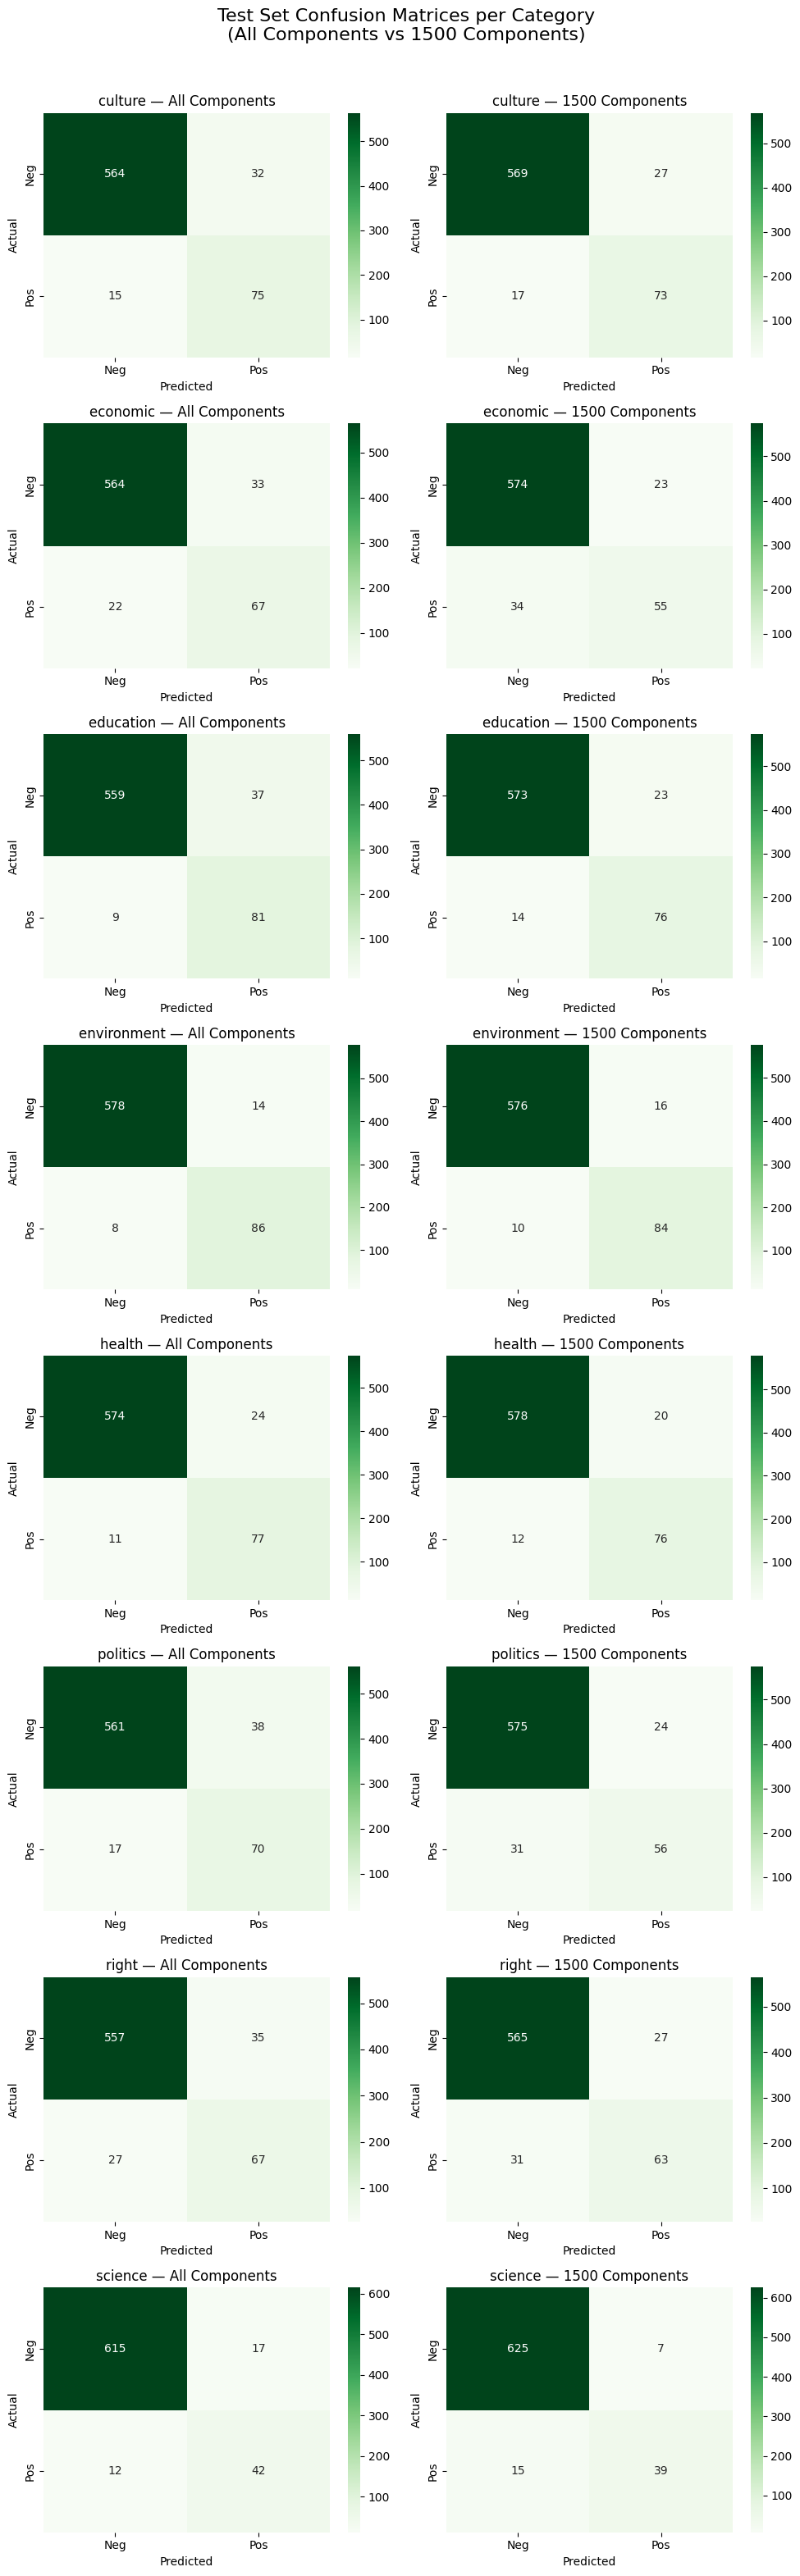

In [50]:
n_labels = len(label_cols)

fig, axes = plt.subplots(
    nrows=n_labels,
    ncols=2,
    figsize=(10, 4 * n_labels)
)

# Make axes 2D safe
if n_labels == 1:
    axes = np.expand_dims(axes, axis=0)

for i, label in enumerate(label_cols):

    # Convert to numpy arrays
    y_true_all = y_test[label].values
    y_pred_all_i = y_pred_all[:, i] if hasattr(y_pred_all, "shape") else y_pred_all[label].values

    cm_all = confusion_matrix(y_true_all, y_pred_all_i)

    sns.heatmap(
        cm_all,
        annot=True,
        fmt="d",
        cmap="Greens",
        ax=axes[i, 0],
        xticklabels=["Neg", "Pos"],
        yticklabels=["Neg", "Pos"]
    )
    axes[i, 0].set_title(f"{label} — All Components")
    axes[i, 0].set_xlabel("Predicted")
    axes[i, 0].set_ylabel("Actual")

    # 1500 components
    y_true_1500 = y_test[label].values
    y_pred_1500_i = y_pred_1500[:, i] if hasattr(y_pred_1500, "shape") else y_pred_1500[label].values

    cm_1500 = confusion_matrix(y_true_1500, y_pred_1500_i)

    sns.heatmap(
        cm_1500,
        annot=True,
        fmt="d",
        cmap="Greens",
        ax=axes[i, 1],
        xticklabels=["Neg", "Pos"],
        yticklabels=["Neg", "Pos"]
    )
    axes[i, 1].set_title(f"{label} — 1500 Components")
    axes[i, 1].set_xlabel("Predicted")
    axes[i, 1].set_ylabel("Actual")

plt.suptitle(
    "Test Set Confusion Matrices per Category\n(All Components vs 1500 Components)",
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
